### Grouping results 
- 1st naively  
- Then with spell checking, Levenshtein minimum edit distance method 

In [ ]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import seaborn as sns
from rapidfuzz import process, fuzz

In [3]:
pip install rapidfuzz


Defaulting to user installation because normal site-packages is not writeable
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# naive grouping

batches = [1, 2, 3, 4, 5]
input_base_folder = "c_structure_annotation/structure_comp"  
output_file = "naive_grouped_annotations.csv"

# Extract query, target, and annotation/protein_descr from all processed CSV files
annotations = []
for batch in batches:
    batch_folder = os.path.join(input_base_folder, f"batch_{batch}")
    if not os.path.exists(batch_folder):
        continue
    
    for file in os.listdir(batch_folder):
        if file.endswith("_processed.csv"):
            file_path = os.path.join(batch_folder, file)
            print(f"\nProcessing file: {file_path}")
            
            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
            
            df.columns = df.columns.str.strip().str.lower()
            print(f"Detected columns: {df.columns.tolist()}")  
            
            annotation_column = None
            if 'annotation' in df.columns:
                annotation_column = 'annotation'
            elif 'protein_descr' in df.columns:
                annotation_column = 'protein_descr'
            else:
                print(f"Skipping {file_path} due to missing 'annotation' or 'protein_descr' column.")
                continue
            
            # Drop rows where annotation is missing
            df = df.dropna(subset=[annotation_column])
            print(f"Rows after dropping NaNs: {len(df)}")
            
            df['query'] = df['query'].astype(str).apply(lambda x: x.split("_relaxed")[0])
            for _, row in df.iterrows():
                annotations.append((row['query'], row['target'], row[annotation_column]))

# Naive grouping (exact match on annotations)
naive_groups = defaultdict(list)
for query, target, annotation in annotations:
    naive_groups[annotation].append(f"{query} ({target})")

grouped_df = pd.DataFrame([(ann, ", ".join(proteins)) for ann, proteins in naive_groups.items()],
                          columns=["Annotation", "Queries (Targets)"])
grouped_df.to_csv(output_file, index=False)

In [ ]:
# filter out warnings and obsolete hits
df_cleaned = df[~df['Annotation'].str.contains("warning|uniprot|id", case=False, na=False)]
singleton_count = df_cleaned['Queries (Targets)'].apply(lambda x: ',' not in str(x)).sum()

4,509 annotations and 2,098 singletons

In [ ]:
def count_queries(cell):
    return len(cell.split(',')) if pd.notnull(cell) else 0

filtered_df['Hit Count'] = filtered_df['Queries (Targets)'].apply(count_queries)

annotation_counts = filtered_df.groupby('Annotation')['Hit Count'].sum().sort_values(ascending=False)
top_n = 20
top_annotations = annotation_counts.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_annotations.values, y=top_annotations.index, palette='magma_r')
plt.xlabel("Number of Hits")
plt.ylabel("Annotation Cluster")
plt.title("FoldSeek Hits Distribution in the Largest Clusters")
plt.tight_layout()
plt.show()

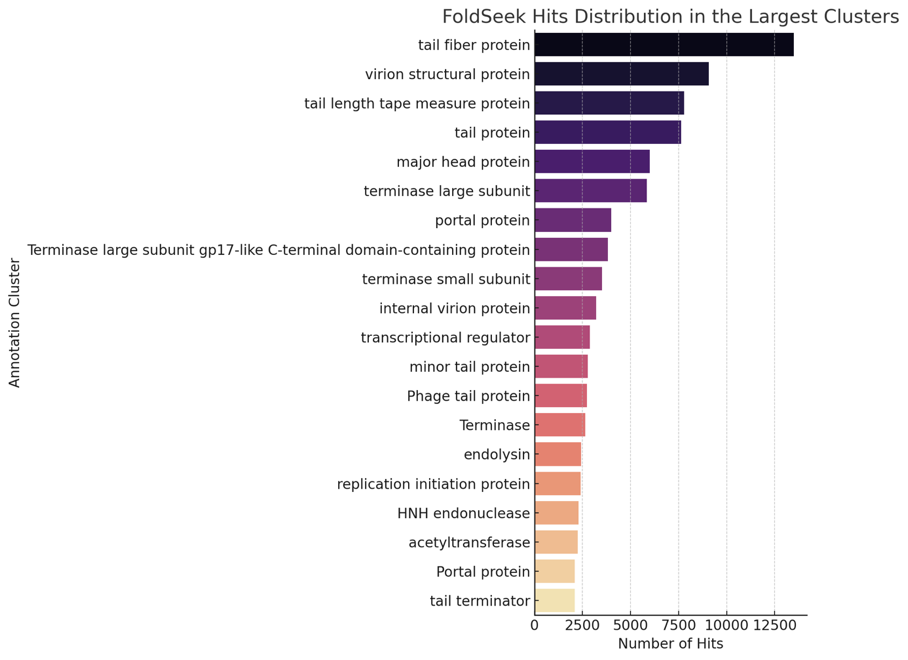

### Levenshtein Distance-Based Clustering
- Loads the previously created naive_grouped_annotations.csv, file contains exact matches from the naive grouping step.
- Extracts the Annotation column as unique annotation labels.
- Uses process.extractOne() from rapidfuzz to find the most similar annotation cluster:
- best_match = process.extractOne(annotation, similarity_groups.keys(), scorer=fuzz.ratio)
- Compares similarity using the fuzz.ratio scorer
- fuzz.ratio computes a normalized Levenshtein distance (similarity score 0-100).
- If the best match has a similarity score ≥ 85%, it is added to the same cluster.
- Otherwise, it starts a new cluster.
- Saves the clustered results into clustered_annotations.csv
- The final output groups together similar annotations instead of just exact matches.


In [ ]:
input_file = "naive_grouped_annotations.csv"
output_file = "clustered_annotations.csv"
df = pd.read_csv(input_file)

naive_groups = {row["Annotation"]: row["Queries (Targets)"] for _, row in df.iterrows()}

#clustering annotations based on similarity
similarity_groups = defaultdict(set)
thresh = 85  # similarity threshold
annotation_list = list(naive_groups.keys())

for annotation in annotation_list:
    best_match = process.extractOne(annotation, similarity_groups.keys(), scorer=fuzz.ratio)
    if best_match and best_match[1] >= thresh:
        similarity_groups[best_match[0]].add(annotation)
    else:
        similarity_groups[annotation].add(annotation)

results = []
for cluster, similar_annotations in similarity_groups.items():
    combined_queries = set()
    for annotation in similar_annotations:
        combined_queries.update(naive_groups.get(annotation, "").split(", "))
    results.append([cluster, ", ".join(combined_queries)])

clustered_df = pd.DataFrame(results, columns=["Annotation Cluster", "Queries (Targets)"])
clustered_df.to_csv(output_file, index=False)

In [ ]:
# filter out warnings and obsolete hits
clean_df = clustered_df[~clustered_df['Annotation'].str.contains("warning|uniprot|id", case=False, na=False)]
singleton_count = clean_df['Queries (Targets)'].apply(lambda x: ',' not in str(x)).sum()

2,852 clusters and 1,199 singletons

In [ ]:

clean_df['Hit Count'] = clean_df['Queries (Targets)'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Group by annotation and sum the hits
annotation_counts = clean_df.groupby('Annotation Cluster')['Hit Count'].sum().sort_values(ascending=False)

# Select top N annotations
top_n = 20
top_annotations = annotation_counts.head(top_n)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_annotations.values, y=top_annotations.index, palette='cubehelix_r')
plt.xlabel("Number of Hits")
plt.ylabel("Annotation Cluster")
plt.title("FoldSeek Hits Distribution in the Largest Clusters")
plt.tight_layout()
plt.show()


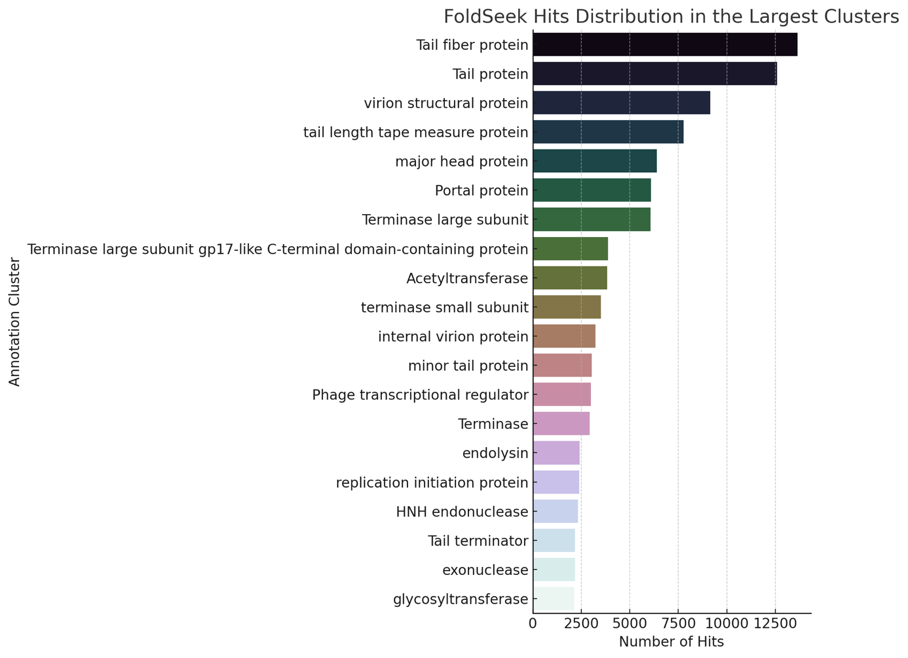